In [ ]:
#| default_exp sampler.tree

This data structure is based on the Python package `anytree` (https://github.com/c0fec0de/anytree)  which has been extended by the classes `Constant`, `Variable` and `CountTree`.

In [ ]:
#| include: false
from nbdev.showdoc import *

In [ ]:
#| export

from anytree import NodeMixin, RenderTree, PreOrderIter
import qsample.math as math
import pydot
import dill as pickle

from fastcore.test import *

# Helper functions
> Functions for plotting and storing tree objects

In [ ]:
#| export

def draw_tree(tree, path=None):
    """Generate and return PNG image of `CountTree` 

    Notes
    -----
    To display the image in command line call .show() on the returned
    PIL image object.

    Parameters
    ----------
    path : str or None
        File path to save png image to, if None only display image

    Returns
    -------
    PNG image
        Image of `CountTree`
    """

    def gen_node(node):
        """
        Parameters
        ----------
        node : Constant or Variable
            `CountNode` to generate pydot.Node object from

        Returns
        -------
        pydot.Node
            Graphical representation of `node`
        """
        label=f"{node.name} : {node.count}"
        if isinstance(node, Variable):
            color = "#ff0000" if node in tree.marked_leaves else "black"
            return pydot.Node(hex(id(node)), label=label, style="filled", color=color, fillcolor="white", shape="ellipse")
        if isinstance(node, Constant):
            return pydot.Node(hex(id(node)), label=label, style="filled", fillcolor="white", shape="box")

    def edgeattrfunc(node, child):
        """
        Parameters
        ----------
        node : Constant or Variable
            Parent node of a (node, child) pair
        child : 
            Child node of a (node, child) pair

        Returns
        -------
        dict
            Specification of the thickness of the edge between `node` and `child`
        """
        weight = 0 if tree.root.count == 0 else 10.0 * child.count / tree.root.count 
        weight = min(weight, 5.0) if weight > 5.0 else max(weight, 0.2)
        return {"penwidth": str(weight)}

    G = pydot.Dot(graph_type="digraph")

    for node in PreOrderIter(tree.root):
        nodeA = gen_node(node)
        G.add_node(nodeA)
        for child in node.children:
            nodeB = gen_node(child)
            edge = pydot.Edge(nodeA,nodeB,**edgeattrfunc(node,child))
            G.add_edge(edge)

    if path is not None:
        G.write_png(path)

    from PIL import Image
    from io import BytesIO
    return Image.open(BytesIO(G.create_png()))

def save(tree, path):
    """Save tree object to `path`
    
    Parameters
    ----------
    tree : CountTree
        Tree object to save
    path : str
        File path to save to
    """
    import numpy as np
    data = to_dict(tree.root)
    data["constants"] = {k: v.tolist() if isinstance(v, np.ndarray) else v for k,v in tree.constants.items()}
    data["marked_leaves"] = [list(tree.root.leaves).index(leaf) for leaf in tree.marked_leaves]
    with open(path, 'wb') as fp:
        pickle.dump(data, fp)
        
def to_dict(node):
    """Convert Tree object to dict
    
    Parameters
    ----------
    node : Constant or Variable
        Node from which to recursively obtain children
    """
    data = dict( list(iter_node_attr(node)) )
    data["node_cls"] = node.__class__.__name__
    children = list( to_dict(child) for child in node.children )
    if children:
        data["children"] = children
    return data

def iter_node_attr(node):
    """Iterate attributes of a node."""
    for k, v in node.__dict__.items():
        if k in ("_NodeMixin__children", "_NodeMixin__parent"):
            continue
        yield k, v

def load(path):
    """Load tree object from `path`
    
    Parameters
    ----------
    path : str
        File path to stored tree object
    
    Returens
    --------
    CountTree
        Tree object
    """
    with open(path, 'rb') as fp:
        data = pickle.load(fp)
    constants = data.pop("constants")
    marked_leaves_ids = data.pop("marked_leaves")
    root = from_dict(data)
    tree = CountTree(constants)
    tree.root = root
    tree.marked_leaves = [tree.root.leaves[i] for i in marked_leaves_ids]
    return tree

def from_dict(data, parent=None):
    """Convert from dict to CountTree object
    
    Parameters
    ----------
    data : dict
        Dict object to convert to CountTree
    parent : Constant or Variable
        Recursively returned Node object
        
    Returns
    -------
    Variable
        root node of CountTree
    """
    assert isinstance(data, dict)
    assert "parent" not in data
    children = data.pop("children", [])
    node_name = data.pop("name")
    node_cls = globals()[ data.pop("node_cls") ]
    node = node_cls(node_name, parent=parent, **data)
    for child in children:
        from_dict(child, parent=node)
    return node

# Node classes
> Atomic data structure carrying sampling data

In [ ]:
#| export   

class CountNode(NodeMixin):
    """Class to represent a tree node of a `CountTree`.
    
    A node in a tree is a uniquely identifiable object containing references
    to at most one parent and possibly many children. The root node has no 
    parent and leaf nodes have not children.
    
    The `CountNode` class complements the common tree node by a `count` attribute
    which represents the number of times a node has been visited during sampling.
    
    Attributes
    ----------
    name : str
        The (not necessarily unique) name of the node
    count : int
        Node visit counter variable
    parent : Node, optional
        Reference to parent node object
    children : list of Node, optional
        List of references to children Node objects
    """
    
    def __init__(self, name, count=0, parent=None, children=None):
        """
        Parameters
        ----------
        name : str
            The (not necessarily unique) name of the node
        count : int
            Initial value of visit counter variable
        parent : Node
            Reference to parent node object
        children : list of Node
            List of references to children Node objects
        """
        self.name = name
        self.parent = parent
        self.count = count
        if children:
            self.children = children
        
    def __str__(self):
        return f"{self.name} ({self.count})"
    
class Constant(CountNode):
    """Subclass of `CountNode` to represent a subset node
    
    Attributes
    ----------
    det : bool
        If true, measurement outcome deterministic and successive circuit node 
        has no variance.
    circuit_id : str
        Reference to corresponding circuit
    """
    
    def __init__(self, name, circuit_id=None, det=False, count=0, parent=None, children=None):
        """
        Parameters
        ----------
        circuit_id: str or None
            Reference to corresponding circuit
        det : bool
            If true, measurement outcome deterministic and successive circuit node 
            has no variance.
        name : str
            The (not necessarily unique) name of the node
        count : int
            Initial value of visit counter variable
        parent : Node
            Reference to parent node object
        children : list of Node
            List of references to children Node objects
        """
        super().__init__(name, count, parent, children)
        self.circuit_id = circuit_id
        self.det = det
        
    
class Variable(CountNode):
    """Subclass of Node to represent a circuit node.
    
    Variable nodes represent differentiable rates `qi` in a tree.
    Differentiability refers to the partial derivatives in the 
    propagation of uncertainty formula for the lower and upper bound
    of the logical failure rate `pL`.
    """
        
    @property
    def rate(self):
        """Method to calculate transition rate from parent node to this node.
        
        Notes
        -----
        We consider `parent.count` coin flips of a Bernoulli random variable X
        for which we would like to determine the rate p that a transition from
        parent node to this node (X=1) took place, i.e.:
        
        .. math:: p(X=1) = self.count / self.parent.count
        
        Returns
        -------
        float
            Value of transition rate in range [0,1]
        """
        if self.is_root: 
            return 1.0
        elif self.parent.count == 0: 
            return 0.0
        else: 
            return self.count / self.parent.count
        
    @property
    def variance(self):
        """Method to calculate the variance of the transition rate between
        the parent node and this node. 
        
        Notes
        -----
        The variance of a sampled Bernoulli random variable is given by:
        
        .. math:: Var(X=1) = p(X=1) * (1-p(X=1)) / self.parent.count
        
        However, as this yields unrealistic especially at the beginning of
        sampling, we use the variance of the Wilson interval here:
        
        .. math:: Var(X=1) = ...
        
        Returns
        -------
        float
            Value of variance of transition rate
        """
        if self.is_root or self.count == 0:
            return 0.0
        else:
            return self.rate * (1 - self.rate) / self.parent.count
    
    def __str__(self):
        return f"{self.name} ({self.count}, {self.variance:.2e})"

# Tree class
> Data structure for sampling process

In [ ]:
#| export            

class CountTree:
    """Class to represent a tree of `Variable` and `Constant` nodes.
    
    Attributes
    ----------
    constants : list
        List of constant values corresponding to weight subsets of circuits
    root : Variable, default: None
        Root node of the tree
    fault_tolerance_level : int
        Level of fault-tolerance, corresponds to total weight of tree branches
        which do not contribute to the tree variance
    marked_leaves : list
        Leaf nodes marked by user
    """
    
    def __init__(self, constants, fault_tolerance_level=1):
        """
        Parameters
        ----------
        constants : list
            List of constant values corresponding to weight subsets of circuits
        fault_tolerance_level : int
            Level of fault-tolerance, corresponds to total weight of tree branches
            which do not contribute to the tree variance
        """
        self.constants = constants
        self.fault_tolerance_level = fault_tolerance_level
        self.root = None
        self.marked_leaves = set()
        
    def add(self, node_type, name, parent=None, **kwargs):
        """Add node of `node_type` and name `name` as child of `parent`.
        
        Parameters
        ----------
        name : str
            Name of node to add
        node_type : Variable or Constant
            Type of node to add
        parent : Variable or Constant, default: None
            Parent of node to add, only root node has no parent
            
        Returns
        -------
        Variable or Constant
            Reference to added node
        """
        if parent is None:
            if self.root is None:
                self.root = Variable(name, **kwargs)
            return self.root
        else:
            child_match = [node for node in parent.children if node.name == name]
            if child_match:
                # tree node already exists
                return child_match[0]
            else:
                # create new tree node
                return node_type(name=name, parent=parent, **kwargs)
    
    @property
    def root_leaf_rate(self):
        """Sum of rates marked leaf Variable node.count / root.count.
        
        Returns
        -------
        float
            Direct MC estimate of logical failure rate
        """
        return sum([node.count / self.root.count for node in self.marked_leaves])
    
    @property
    def root_leaf_variance(self):
        """Variance of root leaf rate
        
        Returns
        -------
        float
            Variance of direct MC estimate of logical failure rate
        """
        p = self.root_leaf_rate
        return p * (1-p) / self.root.count
    
    def __get_node_value(self, node):
        """Lookup the value of a node.
        
        For `Variable` return its `rate`, for `Constant` return a corresponding
        value from the `constants` dict.
        
        Parameters
        ----------
        node : Constant or Variable
            Node for which value is returned
            
        Raises
        ------
        TypeError
            If `node` has different type than `Variable` or `Constant`
        """
        if isinstance(node, Variable):
            return node.rate
        elif isinstance(node, Constant):
            return self.constants[node.circuit_id][node.name]
        else:
            raise TypeError(f"Unknown node type: {type(node)}")
            
    def __get_path_product(self, start_node, end_node):
        """Calculate product of node values from `start_node` to `end_node`
        
        Parameters
        ----------
        start_node : Constant or Variable
            Start node of the path
        end_node : Constant or Variable
            End node of the path
        """
        if start_node == end_node:
            return 1
        else:
            prod = 1
            for node in end_node.iter_path_reverse():
                if node == start_node:
                    # exclude start_node value
                    break
                else:
                    prod *= self.__get_node_value(node)
            return prod
    
    def path_sum(self, start_node, mode):
        """Calculate sum of all paths from `start_node` to its leaves
        
        Parameters
        ----------
        start_node : Variable or Constant
            Node from which to start calculating the sum of paths
        mode : int
            Paths to consider, 0: Only not marked paths, 1: only marked paths, 2: both
            
        Returns
        -------
        float
            Sum of paths
            
        Raises
        ------
        ValueError
            If mode different than 0,1,2
        """
        acc = 0
        if mode == 0:
            # filter leaves not overlapping with marked leaves
            leaves = set(start_node.leaves).difference(self.marked_leaves)
        elif mode == 1:
            # filter leaves overlap with marked leaves
            leaves = set(start_node.leaves).intersection(self.marked_leaves)
        elif mode == 2:
            # all leaves
            leaves = start_node.leaves
        else:
            raise ValueError(f"Unknown mode {mode}. Known modes: 0,1,2")
            
        for leaf in leaves:
            acc += self.__get_path_product(start_node=start_node, end_node=leaf)
        return acc
    
    def __is_invariant_path(self, end_node):
        """Calculate if path from `root` to `end_node`has total weight
        greater than `fault_tolerance_level`.
        
        Parameters
        ----------
        end_node : Variable or Constant
            End node of a path starting from `root`
        """
        path_weight = sum([sum(n.name) for n in end_node.path if not isinstance(n,Variable)])
        return path_weight < self.fault_tolerance_level
    
    def __partial_derivative(self, node, mode):
        """Calculates partial derivative of `node` in `CountTree`.
        
        We calculate the partial derivative as:
        
        .. math:: twig * subtree,
        
        where twig is the path product leading to but excluding `node`'s rate and 
        subtree is the sum of all paths products starting from the children of `node.
        If `node` has a sibling its rate is 1-qi and therefore contributes a negative
        subtree.
        
        Parameters
        ----------
        node : Variable
            Node with respect to which partial derivative is calculated
        mode : int
            Paths to consider, 0: Only not marked paths, 1: only marked paths
            
        Raises
        ------
        Exception
            If a `Variable` (circuit) node has more than one sibling.
        """
        if self.__is_invariant_path(node) or node.parent.det:
            # ignore invariant paths and fault-free deterministic nodes
            return 0
        
        twig = self.__get_path_product(start_node=self.root, end_node=node.parent)
        subtree = self.path_sum(start_node=node, mode=mode)
        if len(node.siblings) == 1:
            subtree -= self.path_sum(start_node=node.siblings[0], mode=mode)
        elif len(node.siblings) > 1:
            raise Exception("Variable nodes can only have at most 1 sibling.")

        return twig * subtree
        
    def uncertainty_propagated_variance(self, mode):
        """Variance of `CountTree` by propagation of uncertainty.
        
        The formula for Gaussian propagation of uncertainty (ignoring the covariance terms) is:
        
        .. math:: Var(p_L) = \sum_n{\frac{\partial p_L}{\partial q_n}^2 V_n}
        
        Notes
        -----
        We can ignore covariance contributions as the random variables underlying 
        transition rates along a path depend on the occurance of a certain outcome
        of the random variables underlying the transition rates of their parents. 
        Therefore, there is no covariance amongst the rates along a path.
        
        Parameters
        ----------
        mode : int
            Paths to consider, 0: Only not marked paths, 1: only marked paths
            
        Raises
        ------
        ValueError
            If mode different than 0,1
        """
        if mode == 0:
            # all Variable nodes, exclude marked leaves
            variables = [n for n in self.root.descendants if isinstance(n, Variable) and set(n.leaves).difference(self.marked_leaves)]
        elif mode == 1:
            # all Variable nodes, exclude not marked leaves
            variables = [n for n in self.root.descendants if isinstance(n, Variable) and set(n.leaves).intersection(self.marked_leaves)]
        else:
            raise ValueError(f"Unknown mode {mode}. Known modes: 0,1")
        
        # keep only one sibling; other is accounted for in subtree difference
        parent_list = [v.parent for v in variables]
        unique_ids = [parent_list.index(x) for x in set(parent_list)]
        variables = [variables[i] for i in unique_ids]
        
        acc = 0
        for node in variables:
            acc += (self.__partial_derivative(node, mode=mode))**2 * node.variance
        return acc

    def __str__(self):
        return '\n'.join([f'{pre}{node}' for pre, _, node in RenderTree(self.root)])
    
    def draw(self, path=None):
        return draw_tree(self, path)
        
    def save(self, path):
        save(self, path)

# Tests
> Verify correct functioning of basic functionality, especially numerics

In [ ]:
# Test 1-level tree

constants = {0: {(0,): 0.8, (1,): 0.1, (2,): 0.05}}
tree = CountTree(constants)
root = tree.add(name='root', node_type=Variable, count=100)
root0 = tree.add(name=(0,), circuit_id=0, node_type=Constant, parent=root, count=40)
root1 = tree.add(name=(1,), circuit_id=0, node_type=Constant, parent=root, count=30)
root2 = tree.add(name=(2,), circuit_id=0, node_type=Constant, parent=root, count=30)
none_0 = tree.add(name='None', node_type=Variable, parent=root0, count=40)
fail_1 = tree.add(name='fail', node_type=Variable, parent=root1, count=20)
none_1 = tree.add(name='None', node_type=Variable, parent=root1, count=10)
fail_2 = tree.add(name='fail', node_type=Variable, parent=root2, count=5)
none_2 = tree.add(name='None', node_type=Variable, parent=root2, count=25)

tree.marked_leaves = set([fail_1, fail_2])
print(tree)

root (100, 0.00e+00)
├── (0,) (40)
│   └── None (40, 0.00e+00)
├── (1,) (30)
│   ├── fail (20, 7.41e-03)
│   └── None (10, 7.41e-03)
└── (2,) (30)
    ├── fail (5, 4.63e-03)
    └── None (25, 4.63e-03)


In [ ]:
# Test numerics 1-level tree

test_eq(tree.root_leaf_rate, 20/100 + 5/100)
test_eq(tree.path_sum(tree.root, mode=1), 0.1 * 20/30 + 0.05 * 5/30)
test_close(tree.path_sum(tree.root, mode=2), 0.8 + 0.1 + 0.05, eps=1e-05)
test_close(tree.uncertainty_propagated_variance(mode=1), 0.1**2 * 7.41e-03 + 0.05**2 * 4.63e-03, eps=1e-05)
test_close(tree.uncertainty_propagated_variance(mode=0), 0.1**2 * 7.41e-03 + 0.05**2 * 4.63e-03, eps=1e-05)

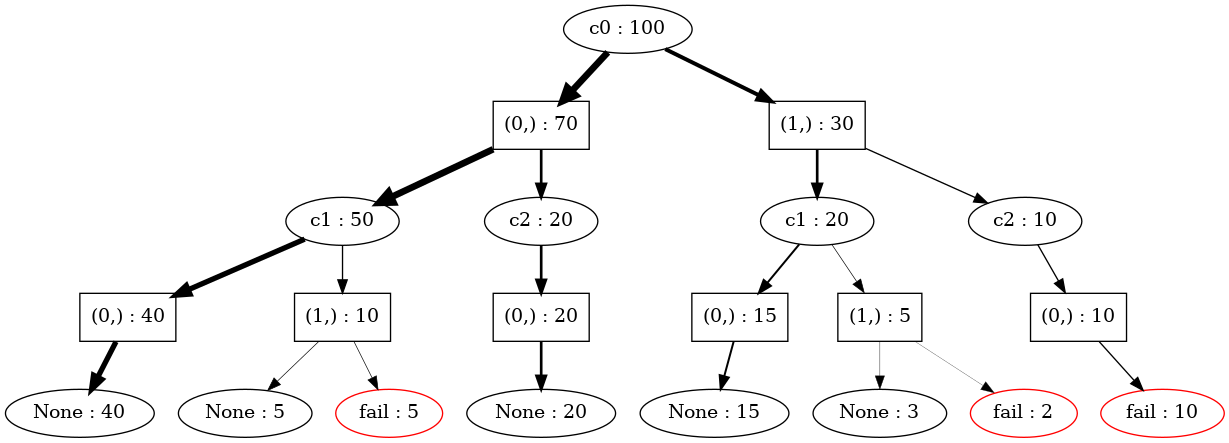

In [ ]:
# Test 2-level tree

constants = {0: {(0,): 0.8, (1,): 0.1}, 
             1: {(0,): 0.7, (1,): 0.2},
             2: {(0,): 1.0}}

tree = CountTree(constants)
root = tree.add(name='c0', node_type=Variable, count=100)
root0 = tree.add(name=(0,), circuit_id=0, node_type=Constant, parent=root, count=70)
root1 = tree.add(name=(1,), circuit_id=0, node_type=Constant, parent=root, count=30)
c1_0 = tree.add(name='c1', node_type=Variable, count=50, parent=root0)
c1_1 = tree.add(name='c1', node_type=Variable, count=20, parent=root1)
c2_0 = tree.add(name='c2', node_type=Variable, count=20, parent=root0)
c2_1 = tree.add(name='c2', node_type=Variable, count=10, parent=root1)

c1_0_0 = tree.add(name=(0,), circuit_id=1, node_type=Constant, parent=c1_0, count=40)
c1_0_1 = tree.add(name=(1,), circuit_id=1, node_type=Constant, parent=c1_0, count=10)
c1_1_0 = tree.add(name=(0,), circuit_id=1, node_type=Constant, parent=c1_1, count=15)
c1_1_1 = tree.add(name=(1,), circuit_id=1, node_type=Constant, parent=c1_1, count=5)

c2_0_0 = tree.add(name=(0,), circuit_id=2, node_type=Constant, parent=c2_0, count=20)
c2_1_0 = tree.add(name=(0,), circuit_id=2, node_type=Constant, parent=c2_1, count=10)

none_c1_0_0 = tree.add(name='None', node_type=Variable, parent=c1_0_0, count=40)
none_c1_0_1 = tree.add(name='None', node_type=Variable, parent=c1_0_1, count=5)
fail_c1_0_1 = tree.add(name='fail', node_type=Variable, parent=c1_0_1, count=5)
none_c1_1_0 = tree.add(name='None', node_type=Variable, parent=c1_1_0, count=15)
none_c1_1_1 = tree.add(name='None', node_type=Variable, parent=c1_1_1, count=3)
fail_c1_1_1 = tree.add(name='fail', node_type=Variable, parent=c1_1_1, count=2)

none_c2_0_0 = tree.add(name='None', node_type=Variable, parent=c2_0_0, count=20)
fail_c2_1_0 = tree.add(name='fail', node_type=Variable, parent=c2_1_0, count=10)

tree.marked_leaves = set([fail_c1_0_1, fail_c1_1_1, fail_c2_1_0])
tree.draw()

In [ ]:
# Test numerics 2-level tree

test_eq(tree.root_leaf_rate, 5/100 + 2/100 + 10/100)
test_eq(tree.path_sum(tree.root, mode=1), 0.8 * 50/70 * 0.2 * 5/10 + 0.1 * (20/30 * 0.2 * 2/5 + 10/30 * 1.0 * 1))
test_close(tree.path_sum(tree.root, mode=2), 0.8 * (50/70 * 0.9 + 20/70) + 0.1 * (20/30 * 0.9 + 10/30), eps=1e-05)
# var1 = (0.8 * 0.2 * 5/10)**2 * c1_0.variance + (0.8 * 50/70 * 0.2)**2 * fail_c1_0_1.variance + (0.1 * 0.2 * 2/5 - 0.1 * 1)**2 * c1_1.variance + (0.1 * 0.2 * 20/30)**2 * fail_c1_1_1.variance
var1 = (0.8 * 50/70 * 0.2)**2 * fail_c1_0_1.variance + (0.1 * 0.2 * 2/5 - 0.1 * 1)**2 * c1_1.variance + (0.1 * 0.2 * 20/30)**2 * fail_c1_1_1.variance # ignore all (intermediate) w=0 paths
test_close(tree.uncertainty_propagated_variance(mode=1), var1, eps=1e-05)
# var2 = (0.8 * (0.7 * 1 + 0.2 * 5/10 - 1))**2 * c1_0.variance + (0.8 * 50/70 * 0.2)**2 * fail_c1_0_1.variance + (0.1 * (0.7 + 0.2*3/5))**2 * c1_1.variance + (0.1 * 20/30 * 0.2)**2 * fail_c1_1_1.variance
var2 = (0.8 * 50/70 * 0.2)**2 * fail_c1_0_1.variance + (0.1 * (0.7 + 0.2*3/5))**2 * c1_1.variance + (0.1 * 20/30 * 0.2)**2 * fail_c1_1_1.variance # ignore all (intermediate) w=0 paths
test_close(tree.uncertainty_propagated_variance(mode=0), var2, eps=1e-05)

In [ ]:
# class CountNode(NodeMixin):
#     """Class to represent a tree node of a `CountTree`.
    
#     A node in a tree is a uniquely identifiable object containing references
#     to at most one parent and possibly many children. The root node has no 
#     parent and leaf nodes have not children.
    
#     The `CountNode` class complements the common tree node by a `count` attribute
#     which represents the number of times a node has been visited during sampling.
    
#     Attributes
#     ----------
#     name : str
#         The (not necessarily unique) name of the node
#     id : int
#         Unique Python object identifier for this node
#     count : int
#         Node visit counter variable
#     parent : Node, optional
#         Reference to parent node object
#     children : list of Node, optional
#         List of references to children Node objects
#     """
    
#     def __init__(self, name, init_count=0, parent=None, children=None):
#         """
#         Parameters
#         ----------
#         name : str
#             The (not necessarily unique) name of the node
#         init_count : int, optional
#             Initial value of visit counter variable
#         parent : Node, optional
#             Reference to parent node object
#         children : list of Node, optional
#             List of references to children Node objects
#         """
#         self.name = name
#         self.parent = parent
#         self.count = init_count
#         self.id = id(self)
#         if children:
#             self.children = children
            
# class Variable(Node):
#     """Subclass of Node to represent a node of variable type.
    
#     Variable nodes represent differentiable rates `qi` in a tree.
#     Differentiability refers to the partial derivatives in the 
#     propagation of uncertainty formula for the lower and upper bound
#     of the logical failure rate `pL`.
    
#     Attributes
#     ----------
#     marked : bool
#         ...
    
#     """
    
#     def __init__(self, name, parent=None, counts=0, marked=False, **kwargs):
#         super().__init__(name, parent)
#         self.counts = counts
#         self.marked = marked
       
#     @property
#     def rate(self):
#         if self.parent.counts == 0: return 0
#         else: return self.counts / self.parent.counts
    
#     def __str__(self):
#         """str: """
#         return f"{self.name} ({self.counts}/{self.parent.counts})"
    
# class Constant(Node):
    
#     def __init__(self, name, parent=None, cid=None, counts=0, is_deterministic=False, **kwargs):
#         super().__init__(name, parent)
#         self.cid = cid
#         self.counts = counts
#         self.is_deterministic = is_deterministic
    
#     @property
#     def variance(self):
#         """Variance of children (Variable) nodes."""
#         if self.is_root or self.counts == 0: return 0
#         else: return math.Wilson_var(self.children[0].rate, self.counts)
    
#     def __str__(self):
#         return f"{self.name} ({self.counts}, {self.variance:.2e})"

In [ ]:
# class CountTree:
    
#     def __init__(self, constants=None, min_path_weight=1):
#         self.constants = constants
#         self.root = None
#         self.min_path_weight = min_path_weight
        
#     def add(self, name, nodetype=None, parent=None, **kwargs):
#         if parent is None:
#             if self.root is None:
#                 self.root = Constant(name, **kwargs)
#             return self.root
        
#         childmatch = [node for node in parent.children if node.name == name]
#         if childmatch:
#             return childmatch[0]
#         else:
#             return nodetype(name, parent=parent, **kwargs)
        
#     def detach(self, node):
#         node.parent = None
        
#     def multiplier(self, node):
#         if node.is_root: return 1
#         elif isinstance(node, Variable): return node.rate
#         elif isinstance(node, Constant): return self.constants[node.cid][node.name]
#         else: raise TypeError(f"Node of type {node.__class__} not recognized.")
        
#     @property
#     def direct_rate(self):
#         cnts = self.root.counts
#         fail_cnts = sum([n.counts for n in self.root.leaves if n.marked])
#         return fail_cnts / cnts
    
#     @property
#     def direct_variance(self):
#         return math.Wilson_var(self.direct_rate, self.root.counts)
        
#     @property
#     def norm(self):
#         acc = 0.0
#         for leaf in self.root.leaves:
#             if not leaf.is_root:
#                 prod = 1.0
#                 for node in leaf.path:
#                     prod *= self.multiplier(node)
#                 acc += prod
#         return acc
    
#     @property
#     def delta(self):
#         return 1.0 - self.norm
    
#     @property
#     def rate(self):
#         acc = 0.0
#         for leaf in self.root.leaves:
#             if leaf.marked:
#                 prod = 1.0
#                 for node in leaf.path:
#                     prod *= self.multiplier(node)
#                 acc += prod
#         return acc
    
#     def twig(self, node):
#         twig = 1.0
#         for node in node.path:
#             twig *= self.multiplier(node)
#         return twig
    
#     def subtree(self, node, all_leaves=False):
#         path_sum = 0.0
                
#         for leaf in node.leaves:
#             if leaf.marked or all_leaves:
#                 if all_leaves and leaf.marked: continue # !!! var of upper bound: need to ignore fail leaf rates. 
                
#                 prod = 1.0
#                 for n in leaf.iter_path_reverse():
#                     if n == node:
#                         break
#                     else:
#                         prod *= self.multiplier(n)
#                 path_sum += prod
        # return path_sum
    
#     def subtreediff(self, node, all_leaves):
#         assert( isinstance(node, Constant) )
#         subtrees = []
#         for child in node.children:
#             subtree = self.subtree(child, all_leaves)
#             subtrees.append(subtree)
#         if len(subtrees) == 1: 
#             return subtrees[0]
#         elif len(subtrees) == 2: return subtrees[0] - subtrees[1]
#         else: raise Exception(f"Node {node.name} must have <= 2 children.")
            
#     def partial_variance(self, node, all_leaves=False):
#         assert isinstance(node, Constant)
#         subtreediff = self.subtreediff(node, all_leaves)
#         return node.variance * subtreediff**2
    
#     def is_invariant_path(self, leaf):
#         path_weight = sum([sum(n.name) for n in leaf.path[1:] if isinstance(n,Constant)])
#         return path_weight < self.min_path_weight
        
#     @property
#     def variance(self):
#         acc = 0.0
#         constants = [node for node in self.root.descendants if isinstance(node, Constant)]
#         for node in constants:
            
#             if node.is_deterministic or (all([c.is_leaf for c in node.children]) and self.is_invariant_path(node)):
#                 continue # exclude deterministic nodes and invariant paths
                
#             twig = self.twig(node)
#             if len(node.children) == 1 and node.children[0].is_leaf:
#                 acc += twig**2 * node.variance
#             else:
#                 acc += twig**2 * self.partial_variance(node)
#         return acc
            
    # @property
    # def norm_variance(self):
    #     acc = 0.0
    #     constants = [node for node in self.root.descendants if isinstance(node, Constant)]
    #     for node in constants:
    #         if node.is_deterministic or self.is_invariant_path(node):
    #             continue
    #         elif all([n.is_leaf for n in node.children]): 
    #             continue
    #         twig = self.twig(node)
    #         acc += twig**2 * self.partial_variance(node, all_leaves=True)
    #     return acc
    
    # @property
    # def variance_ub(self):
    #     acc = 0.0
    #     constants = [node for node in self.root.descendants if isinstance(node, Constant)]
    #     for node in constants:
    #         if node.is_deterministic:
    #             continue
    #         if all([n.is_leaf for n in node.children]) and not any([n.marked for n in node.children]): 
    #             continue
    #         twig = self.twig(node)
    #         acc += twig**2 * self.partial_variance(node, all_leaves=True)
    #     return acc
    
#     def __str__(self):
#         return '\n'.join([f'{pre}{node}' for pre, _, node in RenderTree(self.root)])
    
#     def save(self, path):
#         import numpy as np
#         data = self.to_dict()
#         data["constants"] = {k: v.tolist() if isinstance(v, np.ndarray) else v for k,v in self.constants.items()}
#         with open(path, 'wb') as fp:
#             pickle.dump(data, fp)
    
#     def load(self, path):
#         with open(path, 'rb') as fp:
#             data = pickle.load(fp)
#         self.constants = data.pop("constants")
#         self.from_dict(data)
    
#     def to_dict(self, node=None):
#         if node == None: node = self.root
#         data = dict( list(self._iter_node_attr(node)) )
#         data["node_cls"] = node.__class__.__name__
#         children = list( self.to_dict(child) for child in node.children )
#         if children:
#             data["children"] = children
#         return data
    
#     def from_dict(self, data):
#         self.root = self.__import(data)
        
#     @staticmethod
#     def __import(data, parent=None):
#         assert isinstance(data, dict)
#         assert "parent" not in data
#         children = data.pop("children", [])
#         node_name = data.pop("name")
#         node_cls = globals()[ data.pop("node_cls") ]
#         node = node_cls(node_name, parent=parent, **data)
#         for child in children:
#             CountTree.__import(child, parent=node)
#         return node
    
#     @staticmethod
#     def _iter_node_attr(node):
#         for k, v in node.__dict__.items():
#             if k in ("_NodeMixin__children", "_NodeMixin__parent"):
#                 continue
#             yield k, v
            
#     def draw(self, path=None, scale_percent=100):
        
#         def gen_node(node):
#             if isinstance(node, Variable):
#                 color = "#ff9999" if node.marked else "white"
#                 return pydot.Node(hex(node.id), label=str(node.name), style="filled", fillcolor=color, shape="ellipse")
#             if isinstance(node, Constant):
#                 return pydot.Node(hex(node.id), label=str(node.name), style="filled", fillcolor="white", shape="box")
            
#         def edgeattrfunc(node, child):
#             weight = 0 if self.root.counts == 0 else 10.0 * child.counts / self.root.counts 
#             weight = min(weight, 5.0) if weight > 5.0 else max(weight, 0.2)
#             return {"penwidth": str(weight)}
        
#         G = pydot.Dot(graph_type="digraph")
        
#         for node in PreOrderIter(self.root):
#             nodeA = gen_node(node)
#             G.add_node(nodeA)
#             for child in node.children:
#                 nodeB = gen_node(child)
#                 edge = pydot.Edge(nodeA,nodeB,**edgeattrfunc(node,child))
#                 G.add_edge(edge)
                
#         if path is not None:
#             G.write_png(path)
#         else:
#             try:
#                 from IPython.display import Image, display
#                 return display( Image(G.create_png()) )
#             except:
#                 print('Image can only be drawn in Jupyter notebook.')